In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests

In [3]:
def make_frame(content):
    prices = {}
    for line in content.split('\n'):
        if '{' in line or '}' in line:
            continue
        data = (
            line
            .lstrip().lstrip("'")
            .rstrip().rstrip("',")
            .split(':')
        )
        if len(data) < 3:
            data.append(np.nan)
        secs, price, volume = data
        prices[int(secs)] = (int(price), float(volume))
        
    price_frame = pd.DataFrame(prices, index = ['price', 'volume']).T
    price_frame.index = pd.to_datetime(price_frame.index, unit = 's')
    
    return price_frame

def fetch_from_wiki(item_name):
    # Totally lifted from:
    # https://github.com/osrsbox/osrsbox.github.io/blob/master/_posts/2018-12-14-scraping-the-osrs-wiki-part3.md
    
    # Construction custom user-agent for query
    custom_agent = {
        'User-Agent': 'CSCE421Scraper',
        'From': 'presley.graham@tamu.edu' 
    }
    
    page_title = f'Module:Exchange/{item_name}/Data'

    # Construct the para.meters of the API query
    parameters = {
        'action': 'parse',
        'prop': 'wikitext',
        'format': 'json',
        'page': page_title,
    }

    # Call the API using the custom user-agent and parameters
    result = requests.get('https://oldschool.runescape.wiki/api.php', 
                            headers=custom_agent, 
                            params=parameters).json()
    
    content = result['parse']['wikitext']['*']
    return make_frame(content)

In [4]:
def item_filename(item_name):
    return os.path.join('data', f'{item_name}.csv')

def fetch_from_disk(item_name):
    file_name = item_filename(item_name)
    
    # First, check to make sure the item is actually on disk
    if not os.path.isfile(file_name):
        return None
    
    # Read in the price frame; manually set index to first line
    price_frame = pd.read_csv(file_name).set_index('Unnamed: 0')
    
    # Get rid of the ugly index name
    del price_frame.index.name
    
    return price_frame

In [16]:
from functools import lru_cache

# fetch(item_name) returns
# fetc
@lru_cache(maxsize = None)
def fetch(item_name):
    # check if we have the item data on disk
    # TODO: check if the data is too old
    price_frame = fetch_from_disk(item_name)
    if price_frame is not None:
        return price_frame
    
    # if not, fetch it from the wiki
    price_frame = fetch_from_wiki(item_name)
    # and dump it to a file
    price_frame.to_csv(item_filename(item_name))
    return price_frame

In [6]:
def returns(item_name):
    prices = fetch(item_name)['price']
    return ((prices - prices.shift(1)) / prices).dropna()

def gold_traded(item_name):
    prices = fetch(item_name)['price'] 
    volumes = fetch(item_name)['volume']
    return (prices * volumes).dropna()

In [17]:
from sklearn.linear_model import LinearRegression

def to_2d_array(df):
    if type(df) is pd.Series:
        return df.values.reshape(-1, 1)
    elif type(df) is pd.DataFrame:
        return df.values
    else:
        return df

def beta(pred, resp, plot = False):
    pred_rets, resp_rets = returns(pred), returns(resp)
    common_index = pred_rets.index & resp_rets.index
    pred_rets = pred_rets.reindex(common_index)
    resp_rets = resp_rets.reindex(common_index)
    
    X = to_2d_array(pred_rets)
    y = to_2d_array(resp_rets)
    
    model = LinearRegression(fit_intercept = True)
    model.fit(X, y)
    
    if plot:
        sns.regplot(pred_rets, resp_rets)
    
    return model.coef_[0, 0]

0.480478397698582

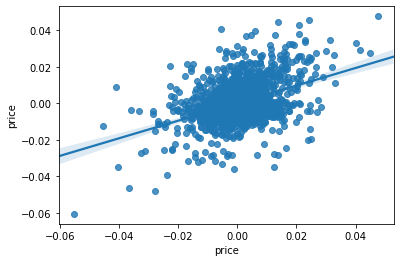

In [18]:
beta('Ranarr weed', 'Prayer potion(4)', True)

In [19]:
gold_traded('Ranarr weed')

2018-12-25    4.206017e+09
2018-12-26    4.380019e+09
2018-12-27    9.353532e+09
2018-12-28    3.363760e+09
2018-12-29    1.004723e+10
                  ...     
2020-01-17    6.702651e+09
2020-01-18    3.245889e+09
2020-01-19    2.849308e+09
2020-01-20    5.573227e+09
2020-01-21    3.279620e+09
Length: 389, dtype: float64

In [20]:
gold_traded('Prayer potion(4)')

2018-12-25    1.028830e+10
2018-12-26    1.057575e+10
2018-12-27    2.471387e+10
2018-12-28    9.047859e+09
2018-12-29    2.435836e+10
                  ...     
2020-01-17    1.763082e+10
2020-01-18    9.223297e+09
2020-01-19    6.580191e+09
2020-01-20    1.393293e+10
2020-01-21    8.162915e+09
Length: 389, dtype: float64